In [503]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_curve, precision_recall_curve

In [504]:
data = pd.read_csv('diabetic_data_training.csv',low_memory=False)

In [505]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
1,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
2,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
3,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [506]:
data.shape

(91589, 50)

In [507]:
duplicates = data[data.duplicated(subset='patient_nbr', keep=False)]
num_duplicates = duplicates.shape[0]
print('Total number of duplicate patients rows:',num_duplicates)

Total number of duplicate patients rows: 40379


In [508]:
# Note: Duplicate instances  

# https://yungchou.github.io/site/ 
    

In [509]:

data_sorted = data.sort_values(by='time_in_hospital', ascending=False)
data = data_sorted.drop_duplicates(subset='patient_nbr', keep='first')
data.reset_index(drop=True, inplace=True) 
# Kept only the first encounter for each 'patient_nbr' with max time_in_hospital

In [510]:
data.shape

(65932, 50)

In [511]:
# Note: Check out features that do not relate to diabetes

In [512]:
features_to_drop = ['encounter_id','payer_code', 'medical_specialty', 'patient_nbr','weight','examide','citoglipton','glimepiride-pioglitazone']
data = data.drop(columns=features_to_drop, axis=1)

In [513]:
print(data['diag_1'].head(),data['diag_2'].head(),data['diag_3'].head())

0      161
1      440
2    250.8
3      486
4      997
Name: diag_1, dtype: object 0    496
1    682
2    518
3    707
4    599
Name: diag_2, dtype: object 0      512
1      707
2      707
3    250.8
4      576
Name: diag_3, dtype: object


In [514]:
columns_to_replace = ['diag_1', 'diag_2', 'diag_3']

for column in columns_to_replace:
    data[column] = data[column].replace('?', 0)
#Replace ? with 0 

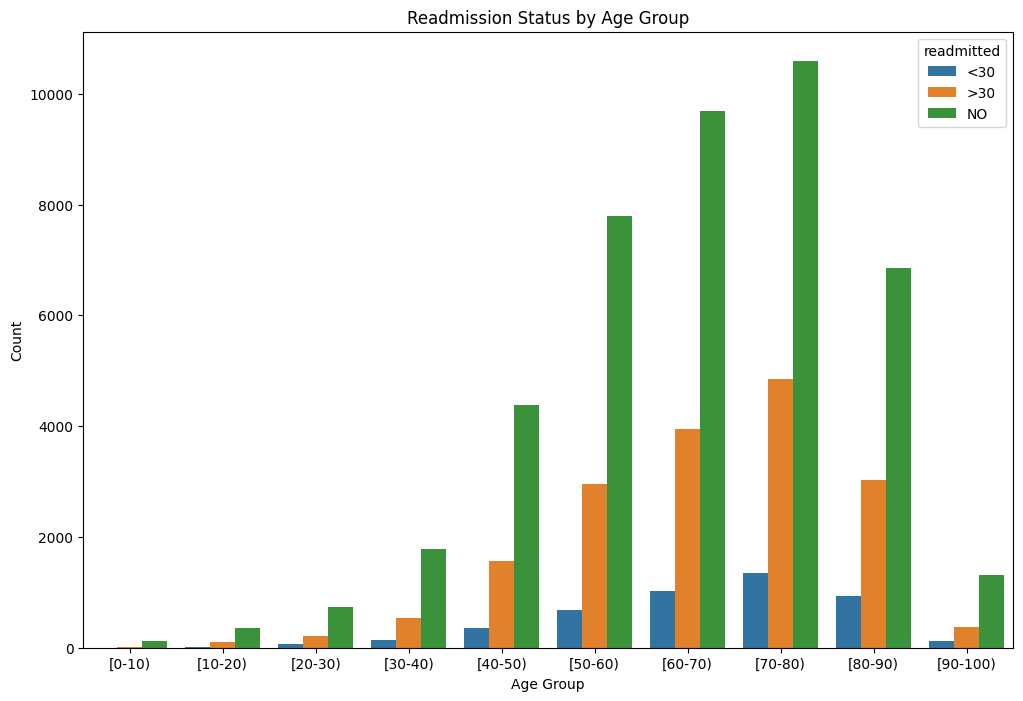

In [515]:


#Readmission vs Age
plt.figure(figsize=(12, 8))
age_order = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
sns.countplot(x='age', hue='readmitted', data=data, order=age_order)
plt.title('Readmission Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

In [516]:
#VISUALIZING VARIOUS FEATURES

/var/folders/8_/qxz3mlm91vb1170qn_1d62p40000gn/T/ipykernel_1204/478604370.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='gender', data=data, palette='pastel')


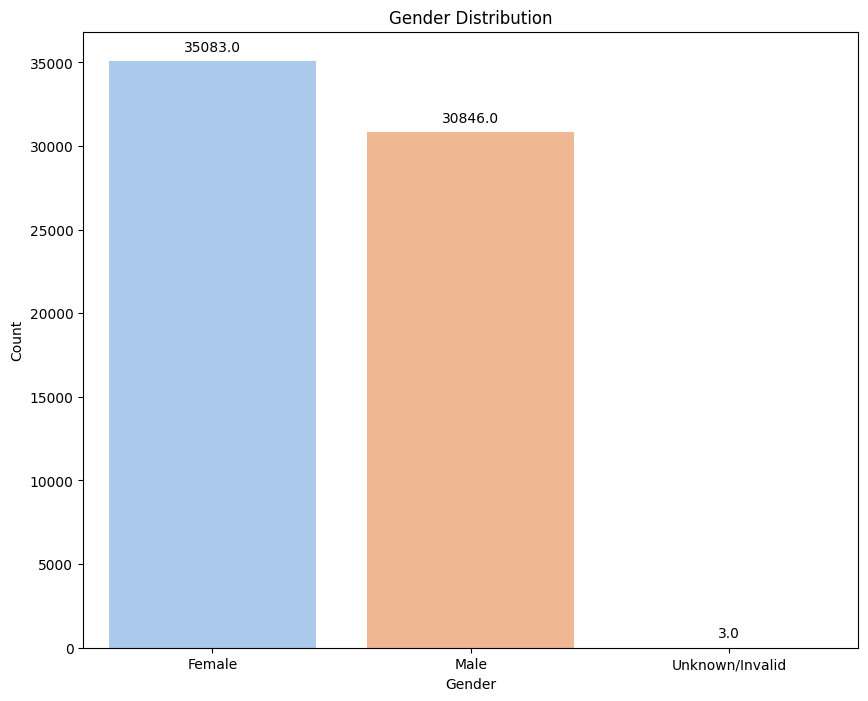

In [517]:
#Gender


plt.figure(figsize=(10, 8))
ax = sns.countplot(x='gender', data=data, palette='pastel')


for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [518]:
# Impute Race with clustering

/var/folders/8_/qxz3mlm91vb1170qn_1d62p40000gn/T/ipykernel_1204/2343171416.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='race', data=data, palette='pastel')


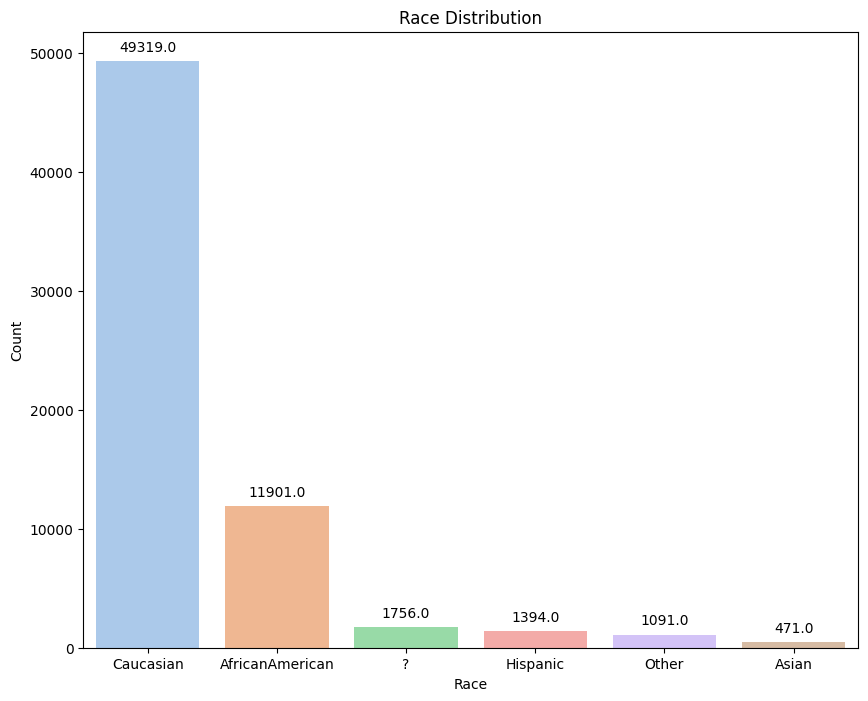

In [519]:
#Race

plt.figure(figsize=(10, 8))
ax = sns.countplot(x='race', data=data, palette='pastel')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

In [520]:

# Label Mapping 
group_mapping = {
    'Circulatory': list(range(390, 460)) + [785],
    'Respiratory': list(range(460, 520)) + [786],
    'Digestive': list(range(520, 580)) + [787],
    'Diabetes': [250 + i / 100.0 for i in range(1, 100)],  # Include decimals from 250.00 to 250.99
    'Injury': list(range(800, 1000)),
    'Musculoskeletal': list(range(710, 740)),
    'Genitourinary': list(range(580, 630)) + [788],
    'Neoplasms': list(range(140, 240)) + [780, 781, 784] + list(range(790, 800)) + list(range(240, 280)) + list(range(680, 710)) + [782] + list(range(1, 140)) + list(range(290, 320))
}

# Assign numerical values to each category
category_numerical_mapping = {
    'Circulatory': 1,
    'Respiratory': 2,
    'Digestive': 3,
    'Diabetes': 4,
    'Injury': 5,
    'Musculoskeletal': 6,
    'Genitourinary': 7,
    'Neoplasms': 8,
}

In [521]:
data['diag_1'] = pd.to_numeric(data['diag_1'],errors='coerce')
data['diag_1_group'] = data['diag_1'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))
data['diag_1_numerical'] = data['diag_1_group'].map(category_numerical_mapping)
data['diag_1_numerical'].fillna(9, inplace=True)
data['diag_1_numerical'] = data['diag_1_numerical'].astype(np.int64)

data['diag_2'] = pd.to_numeric(data['diag_2'],errors='coerce')
data['diag_2_group'] = data['diag_2'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))
data['diag_2_numerical'] = data['diag_2_group'].map(category_numerical_mapping)
data['diag_2_numerical'].fillna(9, inplace=True)
data['diag_2_numerical'] = data['diag_2_numerical'].astype(np.int64)

data['diag_3'] = pd.to_numeric(data['diag_3'],errors='coerce') 
data['diag_3_group'] = data['diag_3'].apply(lambda x: next((k for k, v in group_mapping.items() if x in v), 'Unknown'))
data['diag_3_numerical'] = data['diag_3_group'].map(category_numerical_mapping)
data['diag_3_numerical'].fillna(9, inplace=True)
data['diag_3_numerical'] = data['diag_3_numerical'].astype(np.int64)

print(data[['diag_1', 'diag_1_group', 'diag_1_numerical', 'diag_2', 'diag_2_group', 'diag_2_numerical', 'diag_3', 'diag_3_group', 'diag_3_numerical']].head(40))

    diag_1 diag_1_group  diag_1_numerical  diag_2     diag_2_group  \
0   161.00    Neoplasms                 8  496.00      Respiratory   
1   440.00  Circulatory                 1  682.00        Neoplasms   
2   250.80     Diabetes                 4  518.00      Respiratory   
3   486.00  Respiratory                 2  707.00        Neoplasms   
4   997.00       Injury                 5  599.00    Genitourinary   
5   250.82     Diabetes                 4  788.00    Genitourinary   
6   434.00  Circulatory                 1  780.00        Neoplasms   
7   294.00    Neoplasms                 8  250.81         Diabetes   
8   250.70     Diabetes                 4   40.00        Neoplasms   
9   996.00       Injury                 5  511.00      Respiratory   
10  410.00  Circulatory                 1  428.00      Circulatory   
11     NaN      Unknown                 9  719.00  Musculoskeletal   
12  296.00    Neoplasms                 8  496.00      Respiratory   
13  414.00  Circulat

In [522]:
data.dtypes

race                         object
gender                       object
age                          object
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
diag_1                      float64
diag_2                      float64
diag_3                      float64
number_diagnoses              int64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                    object
glyburide                    object
tolbutamide                 

In [523]:
features_to_drop = ['diag_1', 'diag_2', 'diag_3','diag_1_group','diag_2_group','diag_3_group']
data = data.drop(columns=features_to_drop, axis=1)

In [524]:
drug_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
                'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                'miglitol', 'troglitazone', 'tolazamide', 'insulin',
                'glyburide-metformin', 'glipizide-metformin',
                'metformin-rosiglitazone', 'metformin-pioglitazone']

# Create a new column 'up_count' that counts the number of 'up' values across drug columns
data['up_count'] = data[drug_columns].apply(lambda row: row.eq('Up').sum(), axis=1)
data['down_count'] = data[drug_columns].apply(lambda row: row.eq('Down').sum(), axis=1)
data['steady_count'] = data[drug_columns].apply(lambda row: row.eq('Steady').sum(), axis=1)

In [525]:
data.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted', 'diag_1_numerical', 'diag_2_numerical',
       'diag_3_numerical', 'up_count', 'down_count', 'steady_count'],
      dtype='object')

In [526]:
label_encoder = LabelEncoder()
features_to_encode = ['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
       'diabetesMed', 'readmitted']

for column in features_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

<Axes: >

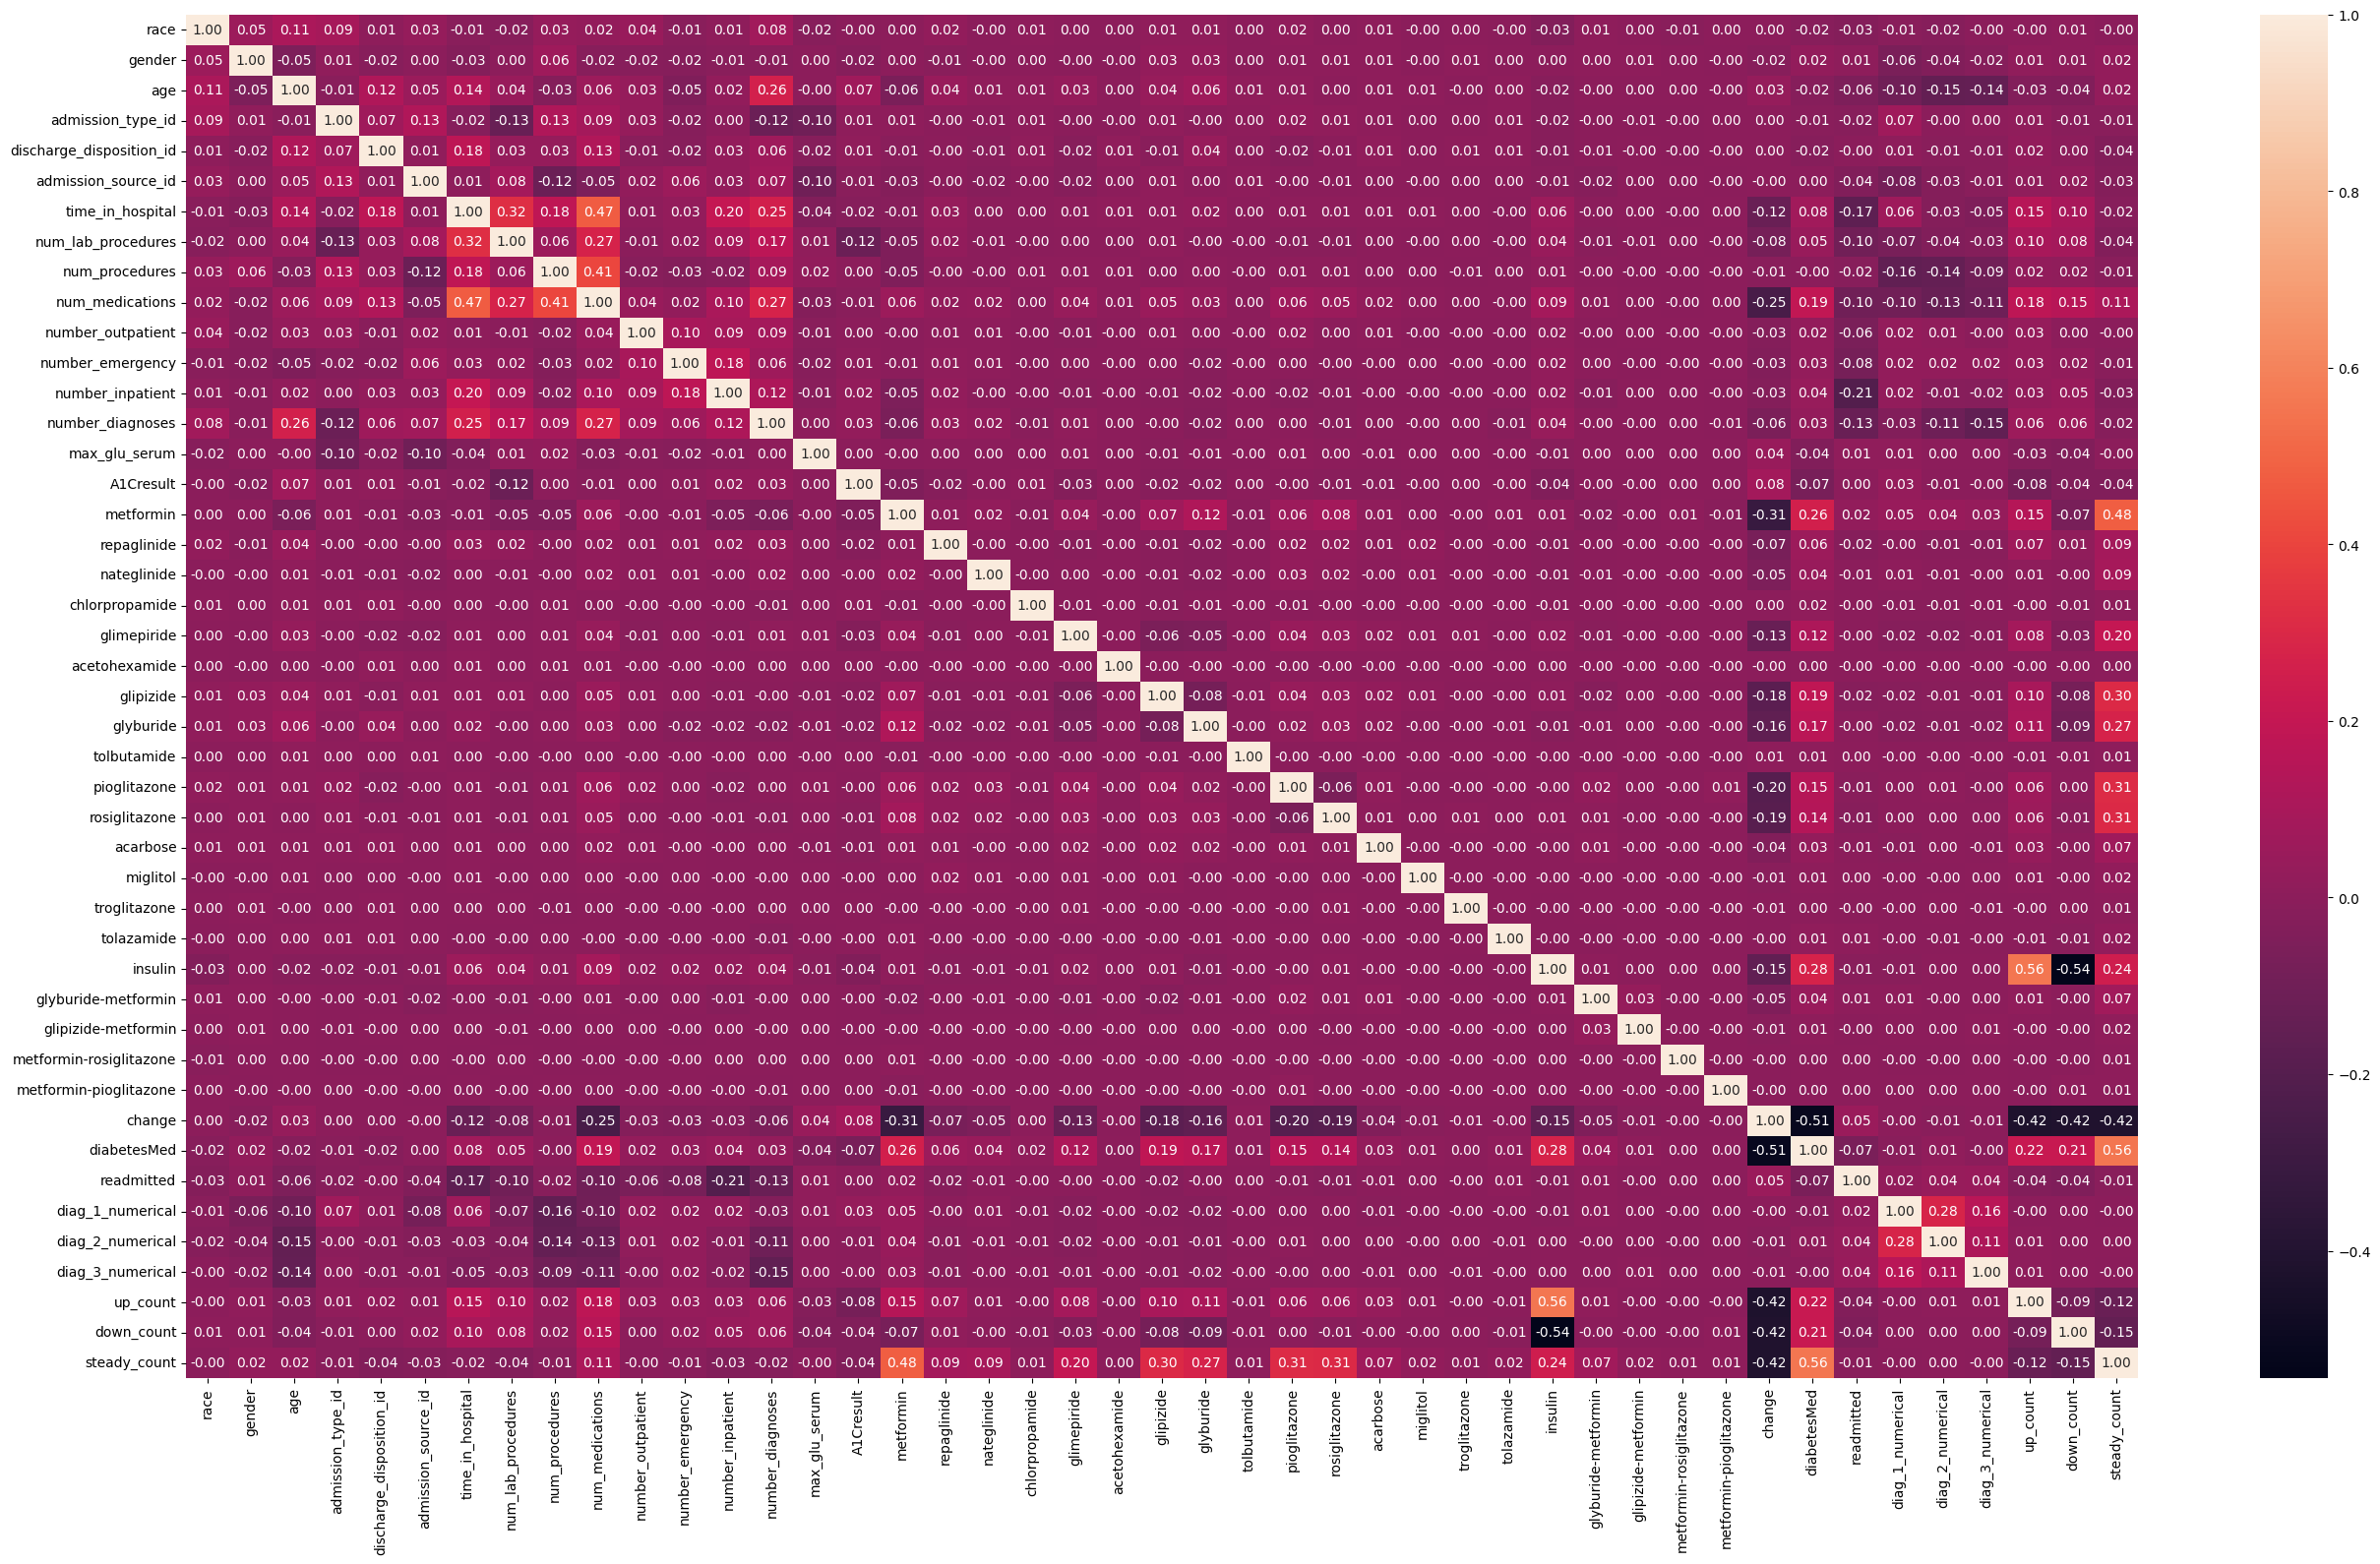

In [527]:
correlation_matrix = data.corr() 
plt.figure(figsize=(32, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")

In [528]:
print(correlation_matrix['readmitted'].sort_values(ascending=False).head(10))
print(correlation_matrix['readmitted'].sort_values(ascending=True).head(10))


readmitted             1.000000
change                 0.050362
diag_3_numerical       0.044355
diag_2_numerical       0.035053
diag_1_numerical       0.022383
metformin              0.020538
max_glu_serum          0.014808
tolazamide             0.006497
glyburide-metformin    0.005435
gender                 0.005132
Name: readmitted, dtype: float64
number_inpatient     -0.210053
time_in_hospital     -0.167198
number_diagnoses     -0.126456
num_medications      -0.102247
num_lab_procedures   -0.097754
number_emergency     -0.077699
diabetesMed          -0.066553
number_outpatient    -0.063010
age                  -0.055475
down_count           -0.044926
Name: readmitted, dtype: float64


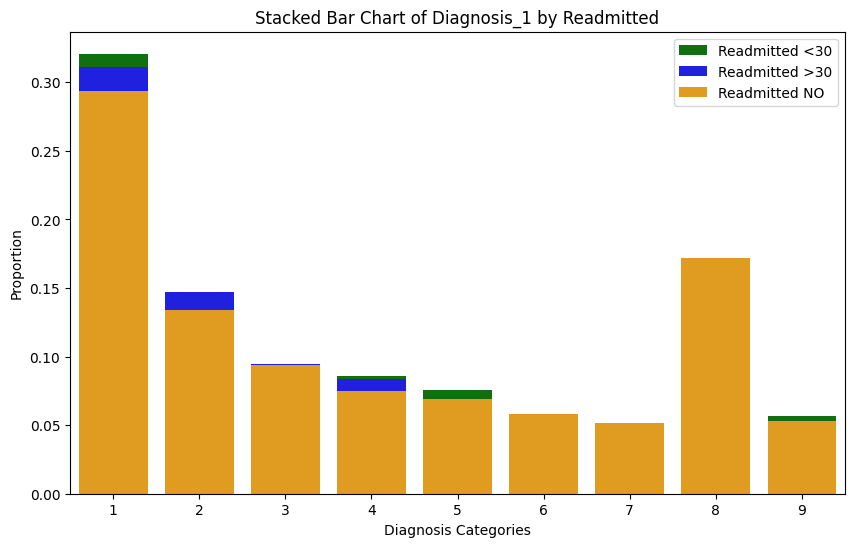

In [529]:
# Group data
grouped_data = data.groupby(['readmitted', 'diag_1_numerical']).size().unstack()

# Normalize the data to get proportions
grouped_data = grouped_data.div(grouped_data.sum(axis=1), axis=0)

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[0], label='Readmitted <30', color='green')
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[1], label='Readmitted >30', color='blue')
sns.barplot(x=grouped_data.columns, y=grouped_data.loc[2], label='Readmitted NO', color='orange')

plt.title('Stacked Bar Chart of Diagnosis_1 by Readmitted')
plt.xlabel('Diagnosis Categories')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [530]:
data['readmitted'].value_counts()

2    43611
1    17637
0     4684
Name: readmitted, dtype: int64

In [531]:
data.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin-pioglitazone,change,diabetesMed,readmitted,diag_1_numerical,diag_2_numerical,diag_3_numerical,up_count,down_count,steady_count
0,3,0,8,1,6,7,14,53,3,12,...,0,1,1,0,8,2,2,0,0,1
1,1,0,7,1,18,7,14,50,3,37,...,0,1,1,0,1,8,8,0,0,1
2,3,0,6,3,3,1,14,64,1,50,...,0,0,1,1,4,2,8,0,1,1
3,3,0,9,2,3,7,14,55,6,17,...,0,0,1,2,2,8,4,0,1,0
4,3,0,7,1,6,7,14,28,2,16,...,0,1,0,1,5,7,3,0,0,0


### Cluster data to impute race column

In [532]:
data.loc[data['race'] == 0, 'race'] = pd.NA

X = data.drop(['readmitted'], axis=1)

n_clusters = 20  # Adjust as needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
X['cluster'] = kmeans.fit_predict(X.drop(['race'], axis=1))

imputer = SimpleImputer(strategy='most_frequent')

for cluster in range(n_clusters):
    cluster_indices = X[X['cluster'] == cluster].index
    data.loc[cluster_indices, 'race'] = imputer.fit_transform(data.loc[cluster_indices, ['race']])

data['race'] = data['race'].astype(np.int64)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [533]:
data['race'].value_counts()

3    51075
1    11901
4     1394
5     1091
2      471
Name: race, dtype: int64

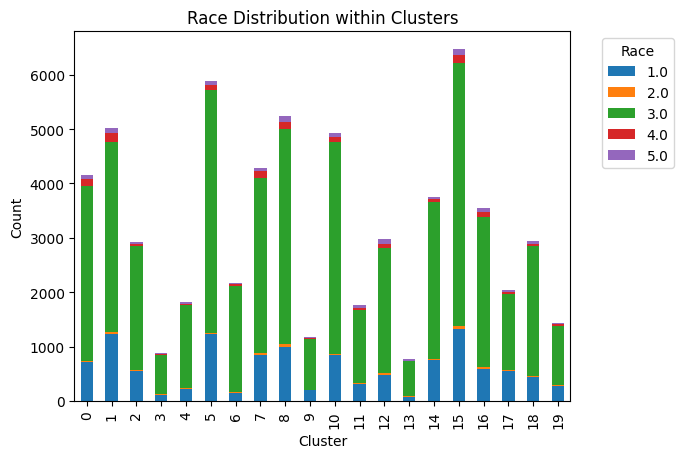

In [534]:
race_distribution = X.groupby(['cluster', 'race']).size().unstack().fillna(0)

race_distribution.plot(kind='bar', stacked=True)
plt.title('Race Distribution within Clusters')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Methodology Overview

### Data Resampling Methods

In [535]:
def get_resampled_dataset_using_smote(data):
    X,y = data.drop(['readmitted'], axis=1), data['readmitted']
    smote = SMOTE(random_state=42)

    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

def get_resampled_dataset_using_tomeklinks(data):
    X,y = data.drop(['readmitted'], axis=1), data['readmitted']
    tomek_links = TomekLinks(sampling_strategy='auto')

    X_resampled, y_resampled = tomek_links.fit_resample(X, y)
    return X_resampled, y_resampled

def get_resampled_dataset_using_smoteTomeklinks(data):
    X,y = data.drop(['readmitted'], axis=1), data['readmitted']
    smote_tomek = SMOTETomek(sampling_strategy='auto')

    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
    return X_resampled, y_resampled

### Feature Engineering Methods

In [536]:
def get_xgboost_feature_importance(X, y, k):
    xgb_model = XGBClassifier()
    xgb_model.fit(X, y)

    feature_importance = xgb_model.get_booster().get_score(importance_type='weight')
    sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

    top_features = [feature[0] for feature in sorted_feature_importance[:k]]
    return X[top_features]

def get_random_forest_feature_importance(X, y, k):
    random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
    random_forest_model.fit(X, y)

    feature_importances = random_forest_model.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    top_features = list(X.columns[indices][:k])
    
    return X[top_features]

def get_lasso_features(X, y):
    lasso_model = Lasso(alpha=0.00001)  
    lasso_model.fit(X, y)
    coefficients = lasso_model.coef_
    feature_names = X.columns

    return X[feature_names[coefficients != 0]]

def get_pca_components(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    n_components = 15  # You can choose the desired number of components

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    columns = [f'PC{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(data=X_pca, columns=columns)

    return pca_df

### Scoring method

In [537]:
def get_cross_validation_scores(model, X, y, num_splits, scoring):
    return cross_validate(model, X, y, cv=StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42), scoring=scoring)

### Predictive Modelling Methods

In [538]:
get_cross_validation_scores(XGBClassifier(), data.drop(['readmitted'], axis=1), data['readmitted'], 5, ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])

{'fit_time': array([2.80724978, 3.91742682, 2.29008579, 2.93081188, 2.15051913]),
 'score_time': array([0.10860395, 0.11926508, 0.08814025, 0.11464906, 0.11668611]),
 'test_accuracy': array([0.67361796, 0.67672708, 0.67306234, 0.67586835, 0.67207644]),
 'test_precision_weighted': array([0.61871668, 0.61723353, 0.61678716, 0.62452933, 0.61230707]),
 'test_recall_weighted': array([0.67361796, 0.67672708, 0.67306234, 0.67586835, 0.67207644]),
 'test_f1_weighted': array([0.61237069, 0.61473997, 0.61107573, 0.61230071, 0.60844613])}

In [539]:
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

def get_xgboost_results(X, y):
    xgboost_model = XGBClassifier()
    cross_validation_scores = get_cross_validation_scores(xgboost_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_random_forest_results(X, y):
    random_forest_model = RandomForestClassifier()
    cross_validation_scores = get_cross_validation_scores(random_forest_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_qda_results(X, y):
    qda_model = QDA()
    cross_validation_scores = get_cross_validation_scores(qda_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_lda_results(X, y):
    lda_model = LDA()
    cross_validation_scores = get_cross_validation_scores(lda_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_knn_results(X, y):
    knn_model = KNeighborsClassifier(n_neighbors = 5)
    cross_validation_scores = get_cross_validation_scores(knn_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_naive_bayes_results(X, y):
    nb_model = GaussianNB()
    cross_validation_scores = get_cross_validation_scores(nb_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]

def get_logistic_regression_results(X, y):
    logistic_regression_model = LogisticRegression()
    cross_validation_scores = get_cross_validation_scores(logistic_regression_model, X, y, 5, scoring_metrics)
    return [cross_validation_scores[f"test_{metric}"].mean() for metric in scoring_metrics]


# Model Training and Validation

In [540]:
final_results = {key: [] for key in ['sampling_method', 'fe_method', 'pm_algorithm', 'scoring_method', 'output']}

In [541]:
fe_methods = ['pca']*4 + ['lasso']*4 + ['random_forest']*4 + ['xgboost']*4 + ['none']*4

In [542]:
final_results

{'sampling_method': [],
 'fe_method': [],
 'pm_algorithm': [],
 'scoring_method': [],
 'output': []}

## Feature Engineered Datasets using Smote Sampling

In [543]:
smote_dataset, y = get_resampled_dataset_using_smote(data)

smote_pca_dataset = get_pca_components(smote_dataset)
smote_lasso_dataset = get_lasso_features(smote_dataset, y)
smote_random_forest_features_dataset = get_random_forest_feature_importance(smote_dataset, y, 15)
smote_xgboost_features_dataset = get_xgboost_feature_importance(smote_dataset, y, 15)

### Training Smote datasets using XGBoost

In [544]:
smote_pca_xgboost = get_xgboost_results(smote_pca_dataset, y)
smote_lasso_xgboost = get_xgboost_results(smote_lasso_dataset, y)
smote_random_forest_features_xgboost = get_xgboost_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_xgboost = get_xgboost_results(smote_xgboost_features_dataset, y)
smote_xgboost = get_xgboost_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["xgboost"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_xgboost+smote_lasso_xgboost+smote_random_forest_features_xgboost+smote_xgboost_features_xgboost+smote_xgboost])


### Training Smote datasets using Random Forest

In [456]:
final_results

{'sampling_method': ['smote', 'smote', 'smote', 'smote', 'smote'],
 'fe_method': ['pca', 'lasso', 'random_forest', 'xgboost', 'none'],
 'pm_algorithm': ['xgboost', 'xgboost', 'xgboost', 'xgboost', 'xgboost'],
 'scoring_method': ['f1', 'f1', 'f1', 'f1', 'f1'],
 'output': [0.584136448858336,
  0.6463724785211397,
  0.6167402234784871,
  0.6128234125241505,
  0.6463724785211397]}

In [457]:
smote_pca_random_forest = get_random_forest_results(smote_pca_dataset, y)
smote_lasso_random_forest = get_random_forest_results(smote_lasso_dataset, y)
smote_random_forest_features_random_forest = get_random_forest_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_random_forest = get_random_forest_results(smote_xgboost_features_dataset, y)
smote_random_forest = get_random_forest_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["random_forest"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_random_forest+smote_lasso_random_forest+smote_random_forest_features_random_forest+smote_xgboost_features_random_forest+smote_random_forest])


### Training Smote datasets using QDA

In [458]:
smote_pca_qda = get_qda_results(smote_pca_dataset, y)
smote_lasso_qda = get_qda_results(smote_lasso_dataset, y)
smote_random_forest_features_qda = get_qda_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_qda = get_qda_results(smote_xgboost_features_dataset, y)
smote_qda = get_qda_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["qda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_qda+smote_lasso_qda+smote_random_forest_features_qda+smote_xgboost_features_qda+smote_qda])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

### Training Smote datasets using LDA

In [459]:
smote_pca_lda = get_lda_results(smote_pca_dataset, y)
smote_lasso_lda = get_lda_results(smote_lasso_dataset, y)
smote_random_forest_features_lda = get_lda_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_lda = get_lda_results(smote_xgboost_features_dataset, y)
smote_lda = get_lda_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["lda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_lda+smote_lasso_lda+smote_random_forest_features_lda+smote_xgboost_features_lda+smote_lda])

### Training Smote datasets using KNN

In [460]:
smote_pca_knn = get_knn_results(smote_pca_dataset, y)
smote_lasso_knn = get_knn_results(smote_lasso_dataset, y)
smote_random_forest_features_knn = get_knn_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_knn = get_knn_results(smote_xgboost_features_dataset, y)
smote_knn = get_knn_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["knn"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_knn+smote_lasso_knn+smote_random_forest_features_knn+smote_xgboost_features_knn+smote_knn])

### Training Smote datasets using Logistic Regression

In [461]:
smote_pca_logistic_regression = get_logistic_regression_results(smote_pca_dataset, y)
smote_lasso_logistic_regression = get_logistic_regression_results(smote_lasso_dataset, y)
smote_random_forest_features_logistic_regression = get_logistic_regression_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_logistic_regression = get_logistic_regression_results(smote_xgboost_features_dataset, y)
smote_logistic_regression = get_logistic_regression_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["logistic_regression"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_logistic_regression+smote_lasso_logistic_regression+smote_random_forest_features_logistic_regression+smote_xgboost_features_logistic_regression+smote_logistic_regression])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Training Smote datasets using Naive Bayes

In [462]:
smote_pca_naive_bayes = get_naive_bayes_results(smote_pca_dataset, y)
smote_lasso_naive_bayes = get_naive_bayes_results(smote_lasso_dataset, y)
smote_random_forest_features_naive_bayes = get_naive_bayes_results(smote_random_forest_features_dataset, y)
smote_xgboost_features_naive_bayes = get_naive_bayes_results(smote_xgboost_features_dataset, y)
smote_naive_bayes = get_naive_bayes_results(smote_dataset, y)

final_results['sampling_method'].extend(["smote"]*20)
final_results['pm_algorithm'].extend(["naive_bayes"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_pca_naive_bayes+smote_lasso_naive_bayes+smote_random_forest_features_naive_bayes+smote_xgboost_features_naive_bayes+smote_naive_bayes])

## Feature Engineered Datasets using Tomek Links Sampling

In [545]:
tomek_links_dataset, y = get_resampled_dataset_using_tomeklinks(data)

tomek_links_pca_dataset = get_pca_components(tomek_links_dataset)
tomek_links_lasso_dataset = get_lasso_features(tomek_links_dataset, y)
tomek_links_random_forest_features_dataset = get_random_forest_feature_importance(tomek_links_dataset, y, 15)
tomek_links_xgboost_features_dataset = get_xgboost_feature_importance(tomek_links_dataset, y, 15)

### Training tomek_links datasets using XGBoost

In [546]:
tomek_links_pca_xgboost = get_xgboost_results(tomek_links_pca_dataset, y)
tomek_links_lasso_xgboost = get_xgboost_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_xgboost = get_xgboost_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_xgboost = get_xgboost_results(tomek_links_xgboost_features_dataset, y)
tomek_links_xgboost = get_xgboost_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["xgboost"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_xgboost+tomek_links_lasso_xgboost+tomek_links_random_forest_features_xgboost+tomek_links_xgboost_features_xgboost+tomek_links_xgboost])

### Training tomek_links datasets using Random Forest

In [465]:
tomek_links_pca_random_forest = get_random_forest_results(tomek_links_pca_dataset, y)
tomek_links_lasso_random_forest = get_random_forest_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_random_forest = get_random_forest_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_random_forest = get_random_forest_results(tomek_links_xgboost_features_dataset, y)
tomek_links_random_forest = get_random_forest_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["random_forest"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_random_forest+tomek_links_lasso_random_forest+tomek_links_random_forest_features_random_forest+tomek_links_xgboost_features_random_forest+tomek_links_random_forest])

### Training tomek_links datasets using QDA


In [466]:
tomek_links_pca_qda = get_qda_results(tomek_links_pca_dataset, y)
tomek_links_lasso_qda = get_qda_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_qda = get_qda_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_qda = get_qda_results(tomek_links_xgboost_features_dataset, y)
tomek_links_qda = get_qda_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["qda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_qda+tomek_links_lasso_qda+tomek_links_random_forest_features_qda+tomek_links_xgboost_features_qda+tomek_links_qda])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

### Training tomek_links datasets using LDA


In [467]:
tomek_links_pca_lda = get_lda_results(tomek_links_pca_dataset, y)
tomek_links_lasso_lda = get_lda_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_lda = get_lda_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_lda = get_lda_results(tomek_links_xgboost_features_dataset, y)
tomek_links_lda = get_lda_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["lda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_lda+tomek_links_lasso_lda+tomek_links_random_forest_features_lda+tomek_links_xgboost_features_lda+tomek_links_lda])

### Training tomek_links datasets using KNN


In [468]:
tomek_links_pca_knn = get_knn_results(tomek_links_pca_dataset, y)
tomek_links_lasso_knn = get_knn_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_knn = get_knn_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_knn = get_knn_results(tomek_links_xgboost_features_dataset, y)
tomek_links_knn = get_knn_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["knn"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_knn+tomek_links_lasso_knn+tomek_links_random_forest_features_knn+tomek_links_xgboost_features_knn+tomek_links_knn])

### Training tomek_links datasets using Logistic Regression


In [469]:
tomek_links_pca_logistic_regression = get_logistic_regression_results(tomek_links_pca_dataset, y)
tomek_links_lasso_logistic_regression = get_logistic_regression_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_logistic_regression = get_logistic_regression_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_logistic_regression = get_logistic_regression_results(tomek_links_xgboost_features_dataset, y)
tomek_links_logistic_regression = get_logistic_regression_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["logistic_regression"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_logistic_regression+tomek_links_lasso_logistic_regression+tomek_links_random_forest_features_logistic_regression+tomek_links_xgboost_features_logistic_regression+tomek_links_logistic_regression])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Training tomek_links datasets using Naive Bayes


In [470]:
tomek_links_pca_naive_bayes = get_naive_bayes_results(tomek_links_pca_dataset, y)
tomek_links_lasso_naive_bayes = get_naive_bayes_results(tomek_links_lasso_dataset, y)
tomek_links_random_forest_features_naive_bayes = get_naive_bayes_results(tomek_links_random_forest_features_dataset, y)
tomek_links_xgboost_features_naive_bayes = get_naive_bayes_results(tomek_links_xgboost_features_dataset, y)
tomek_links_naive_bayes = get_naive_bayes_results(tomek_links_dataset, y)

final_results['sampling_method'].extend(["tomek_links"]*20)
final_results['pm_algorithm'].extend(["naive_bayes"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([tomek_links_pca_naive_bayes+tomek_links_lasso_naive_bayes+tomek_links_random_forest_features_naive_bayes+tomek_links_xgboost_features_naive_bayes+tomek_links_naive_bayes])

## Feature Engineered Datasets using Smote-Tomek Links Sampling

In [547]:
smote_tomek_links_dataset, y = get_resampled_dataset_using_smoteTomeklinks(data)

smote_tomek_links_pca_dataset = get_pca_components(smote_tomek_links_dataset)
smote_tomek_links_lasso_dataset = get_lasso_features(smote_tomek_links_dataset, y)
smote_tomek_links_random_forest_features_dataset = get_random_forest_feature_importance(smote_tomek_links_dataset, y, 15)
smote_tomek_links_xgboost_features_dataset = get_xgboost_feature_importance(smote_tomek_links_dataset, y, 15)

### Training smote_tomek_links datasets using XGBoost


In [548]:
smote_tomek_links_pca_xgboost = get_xgboost_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_xgboost = get_xgboost_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_xgboost = get_xgboost_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_xgboost = get_xgboost_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_xgboost = get_xgboost_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["xgboost"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_xgboost+smote_tomek_links_lasso_xgboost+smote_tomek_links_random_forest_features_xgboost+smote_tomek_links_xgboost_features_xgboost+smote_tomek_links_xgboost])

### Training smote_tomek_links datasets using Random Forest

In [473]:
smote_tomek_links_pca_random_forest = get_random_forest_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_random_forest = get_random_forest_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_random_forest = get_random_forest_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_random_forest = get_random_forest_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_random_forest = get_random_forest_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["random_forest"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_random_forest+smote_tomek_links_lasso_random_forest+smote_tomek_links_random_forest_features_random_forest+smote_tomek_links_xgboost_features_random_forest+smote_tomek_links_random_forest])

### Training smote_tomek_links datasets using QDA

In [474]:
smote_tomek_links_pca_qda = get_qda_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_qda = get_qda_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_qda = get_qda_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_qda = get_qda_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_qda = get_qda_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["qda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_qda+smote_tomek_links_lasso_qda+smote_tomek_links_random_forest_features_qda+smote_tomek_links_xgboost_features_qda+smote_tomek_links_qda])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

### Training smote_tomek_links datasets using LDA

In [475]:
smote_tomek_links_pca_lda = get_lda_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_lda = get_lda_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_lda = get_lda_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_lda = get_lda_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_lda = get_lda_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["lda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_lda+smote_tomek_links_lasso_lda+smote_tomek_links_random_forest_features_lda+smote_tomek_links_xgboost_features_lda+smote_tomek_links_lda])

### Training smote_tomek_links datasets using KNN

In [476]:
smote_tomek_links_pca_knn = get_knn_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_knn = get_knn_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_knn = get_knn_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_knn = get_knn_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_knn = get_knn_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["knn"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_knn+smote_tomek_links_lasso_knn+smote_tomek_links_random_forest_features_knn+smote_tomek_links_xgboost_features_knn+smote_tomek_links_knn])

### Training smote_tomek_links datasets using Logistic Regression

In [477]:
smote_tomek_links_pca_logistic_regression = get_logistic_regression_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_logistic_regression = get_logistic_regression_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_logistic_regression = get_logistic_regression_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_logistic_regression = get_logistic_regression_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_logistic_regression = get_logistic_regression_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["logistic_regression"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_logistic_regression+smote_tomek_links_lasso_logistic_regression+smote_tomek_links_random_forest_features_logistic_regression+smote_tomek_links_xgboost_features_logistic_regression+smote_tomek_links_logistic_regression])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Training smote_tomek_links datasets using Naive Bayes

In [478]:
smote_tomek_links_pca_naive_bayes = get_naive_bayes_results(smote_tomek_links_pca_dataset, y)
smote_tomek_links_lasso_naive_bayes = get_naive_bayes_results(smote_tomek_links_lasso_dataset, y)
smote_tomek_links_random_forest_features_naive_bayes = get_naive_bayes_results(smote_tomek_links_random_forest_features_dataset, y)
smote_tomek_links_xgboost_features_naive_bayes = get_naive_bayes_results(smote_tomek_links_xgboost_features_dataset, y)
smote_tomek_links_naive_bayes = get_naive_bayes_results(smote_tomek_links_dataset, y)

final_results['sampling_method'].extend(["smote_tomek_links"]*20)
final_results['pm_algorithm'].extend(["naive_bayes"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([smote_tomek_links_pca_naive_bayes+smote_tomek_links_lasso_naive_bayes+smote_tomek_links_random_forest_features_naive_bayes+smote_tomek_links_xgboost_features_naive_bayes+smote_tomek_links_naive_bayes])

## Feature Engineered Datasets Without Sampling

In [549]:
no_sampling_dataset, y = get_resampled_dataset_using_smoteTomeklinks(data)

no_sampling_pca_dataset = get_pca_components(no_sampling_dataset)
no_sampling_lasso_dataset = get_lasso_features(no_sampling_dataset, y)
no_sampling_random_forest_features_dataset = get_random_forest_feature_importance(no_sampling_dataset, y, 15)
no_sampling_xgboost_features_dataset = get_xgboost_feature_importance(no_sampling_dataset, y, 15)

### Training no_sampling datasets using XGBoost


In [550]:
no_sampling_pca_xgboost = get_xgboost_results(no_sampling_pca_dataset, y)
no_sampling_lasso_xgboost = get_xgboost_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_xgboost = get_xgboost_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_xgboost = get_xgboost_results(no_sampling_xgboost_features_dataset, y)
no_sampling_xgboost = get_xgboost_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["xgboost"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_xgboost+no_sampling_lasso_xgboost+no_sampling_random_forest_features_xgboost+no_sampling_xgboost_features_xgboost+no_sampling_xgboost])

### Training no_sampling datasets using Random Forest

In [481]:
no_sampling_pca_random_forest = get_random_forest_results(no_sampling_pca_dataset, y)
no_sampling_lasso_random_forest = get_random_forest_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_random_forest = get_random_forest_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_random_forest = get_random_forest_results(no_sampling_xgboost_features_dataset, y)
no_sampling_random_forest = get_random_forest_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["random_forest"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_random_forest+no_sampling_lasso_random_forest+no_sampling_random_forest_features_random_forest+no_sampling_xgboost_features_random_forest+no_sampling_random_forest])

### Training no_sampling datasets using QDA

In [482]:
no_sampling_pca_qda = get_qda_results(no_sampling_pca_dataset, y)
no_sampling_lasso_qda = get_qda_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_qda = get_qda_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_qda = get_qda_results(no_sampling_xgboost_features_dataset, y)
no_sampling_qda = get_qda_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["qda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_qda+no_sampling_lasso_qda+no_sampling_random_forest_features_qda+no_sampling_xgboost_features_qda+no_sampling_qda])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Library/F

### Training no_sampling datasets using LDA

In [488]:
print(final_results['sampling_method'][::-1])
print(final_results['fe_method'][::-1])
print(final_results['pm_algorithm'][::-1])


['no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'no_sampling', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'smote_tomek_links', 'tomek_links', 'tomek_links', 'tomek_li

In [489]:
no_sampling_pca_lda = get_lda_results(no_sampling_pca_dataset, y)
no_sampling_lasso_lda = get_lda_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_lda = get_lda_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_lda = get_lda_results(no_sampling_xgboost_features_dataset, y)
no_sampling_lda = get_lda_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["lda"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_lda+no_sampling_lasso_lda+no_sampling_random_forest_features_lda+no_sampling_xgboost_features_lda+no_sampling_lda])

### Training no_sampling datasets using KNN

In [490]:
no_sampling_pca_knn = get_knn_results(no_sampling_pca_dataset, y)
no_sampling_lasso_knn = get_knn_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_knn = get_knn_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_knn = get_knn_results(no_sampling_xgboost_features_dataset, y)
no_sampling_knn = get_knn_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["knn"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_knn+no_sampling_lasso_knn+no_sampling_random_forest_features_knn+no_sampling_xgboost_features_knn+no_sampling_knn])

### Training no_sampling datasets using Logistic Regression

In [491]:
no_sampling_pca_logistic_regression = get_logistic_regression_results(no_sampling_pca_dataset, y)
no_sampling_lasso_logistic_regression = get_logistic_regression_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_logistic_regression = get_logistic_regression_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_logistic_regression = get_logistic_regression_results(no_sampling_xgboost_features_dataset, y)
no_sampling_logistic_regression = get_logistic_regression_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["logistic_regression"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend([no_sampling_pca_logistic_regression+no_sampling_lasso_logistic_regression+no_sampling_random_forest_features_logistic_regression+no_sampling_xgboost_features_logistic_regression+no_sampling_logistic_regression])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

### Training no_sampling datasets using Naive Bayes

In [492]:
no_sampling_pca_naive_bayes = get_naive_bayes_results(no_sampling_pca_dataset, y)
no_sampling_lasso_naive_bayes = get_naive_bayes_results(no_sampling_lasso_dataset, y)
no_sampling_random_forest_features_naive_bayes = get_naive_bayes_results(no_sampling_random_forest_features_dataset, y)
no_sampling_xgboost_features_naive_bayes = get_naive_bayes_results(no_sampling_xgboost_features_dataset, y)
no_sampling_naive_bayes = get_naive_bayes_results(no_sampling_dataset, y)

final_results['sampling_method'].extend(["no_sampling"]*20)
final_results['pm_algorithm'].extend(["naive_bayes"]*20)
final_results['scoring_method'].extend(scoring_metrics*5)
final_results['fe_method'].extend(fe_methods)
final_results['output'].extend(no_sampling_pca_naive_bayes+no_sampling_lasso_naive_bayes+no_sampling_random_forest_features_naive_bayes+no_sampling_xgboost_features_naive_bayes+no_sampling_naive_bayes)

In [558]:
final_results['output'] = [item for ]

[[0.6008423239764886,
  0.5885508197315522,
  0.6008423239764886,
  0.5847698437741349,
  0.6565316237162603,
  0.6507658373664744,
  0.6565316237162603,
  0.6463724785211397,
  0.6195836968249208,
  0.6160329494811404,
  0.6195836968249208,
  0.6167402234784871,
  0.6151964635243263,
  0.611909985958329,
  0.6151964635243263,
  0.6128234125241505,
  0.6565316237162603,
  0.6507658373664744,
  0.6565316237162603,
  0.6463724785211397],
 [0.6868470110949468,
  0.6046059019080398,
  0.6868470110949468,
  0.6126318578966959,
  0.6987083899485057,
  0.6419257031554306,
  0.6987083899485057,
  0.6357845453714789,
  0.6947367788536549,
  0.6328272322888931,
  0.6947367788536549,
  0.6300302545299203,
  0.6972771461184328,
  0.6398141785160076,
  0.6972771461184328,
  0.6345145876312482,
  0.6971339710078042,
  0.6360867555339645,
  0.6971339710078042,
  0.6336494622548511],
 [0.6002989843888412,
  0.5867124931702932,
  0.6002989843888412,
  0.5830532852432382,
  0.6582964755079319,
  0.65199

In [551]:
final_results_df = pd.DataFrame(final_results)

ValueError: All arrays must be of the same length

In [ ]:
final_results_df.to_csv('xgboost_results.csv')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [557]:
no_sampling_pca_xgboost + no_sampling_lasso_xgboost + no_sampling_random_forest_features_xgboost

[0.6008668578616946,
 0.5876448918784327,
 0.6008668578616946,
 0.583428832505789,
 0.6588383776433526,
 0.652602991626115,
 0.6588383776433526,
 0.6480055444172093,
 0.6206688235193869,
 0.6168809095890321,
 0.6206688235193869,
 0.6175303466161713]

### Playing around with XGBoost

In [ ]:
X = data.drop('readmitted', axis=1)
y = data['readmitted']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print(f"f1: {f1}")

Accuracy: 0.6801395313566391


In [ ]:
X = result_df.drop('readmitted', axis=1)
y = result_df['readmitted']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred)
print(f"f1: {f1}")

Accuracy: 0.6695230150906195
